In [1]:
# Imports
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit, least_squares
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import interp1d
from astropy.table import Table
import matplotlib.colors as colors
from scipy.special import wofz
%matplotlib inline

In [2]:
ls data\spec_reduction_data\HD12707_comb.fits

 Volume in drive C is OS
 Volume Serial Number is 4E89-5B0C

 Directory of C:\Users\WillsPc\GitHub\ObservationalAstro_PHSX491\inclass_activities\data\spec_reduction_data

11/30/2021  09:32 AM         1,350,720 HD12707_comb.fits
               1 File(s)      1,350,720 bytes
               0 Dir(s)  283,075,239,936 bytes free


In [3]:
path = 'data/spec_reducation_data/'

In [4]:
def gaussbin(x, amp, cen, sig, const=0, dx=1.0):
    """1-D gaussian with pixel binning
    
    This function returns a binned Gaussian
    par = [height, center, sigma]
    
    Parameters
    ----------
    x : array
       The array of X-values.
    amp : float
       The Gaussian height/amplitude.
    cen : float
       The central position of the Gaussian.
    sig : float
       The Gaussian sigma.
    const : float, optional, default=0.0
       A constant offset.
    dx : float, optional, default=1.0
      The width of each "pixel" (scalar).
    
    Returns
    -------
    geval : array
          The binned Gaussian in the pixel

    """

    xcen = np.array(x)-cen             # relative to the center
    x1cen = xcen - 0.5*dx  # left side of bin
    x2cen = xcen + 0.5*dx  # right side of bin

    t1cen = x1cen/(np.sqrt(2.0)*sig)  # scale to a unitless Gaussian
    t2cen = x2cen/(np.sqrt(2.0)*sig)

    # For each value we need to calculate two integrals
    #  one on the left side and one on the right side

    # Evaluate each point
    #   ERF = 2/sqrt(pi) * Integral(t=0-z) exp(-t^2) dt
    #   negative for negative z
    geval_lower = erf(t1cen)
    geval_upper = erf(t2cen)

    geval = amp*np.sqrt(2.0)*sig * np.sqrt(np.pi)/2.0 * ( geval_upper - geval_lower )
    geval += const   # add constant offset

    return geval


In [5]:
def gaussian(x, amp, cen, sig, const=0):
    """1-D gaussian: gaussian(x, amp, cen, sig)"""
    return amp * np.exp(-(x-cen)**2 / (2*sig**2)) + const

In [6]:
def gaussfit(x,y,initpar=None,sigma=None,bounds=(-np.inf,np.inf),binned=False):
    """Fit a Gaussian to data."""
    if initpar is None:
        initpar = [np.max(y),x[np.argmax(y)],1.0,np.median(y)]
    func = gaussian
    if binned is True: func=gaussbin
    return curve_fit(func, x, y, p0=initpar, sigma=sigma, bounds=bounds)

In [7]:
# Load the object spectrum 2D image
im,head = fits.getdata('data\spec_reduction_data\HD12707_comb.fits'.replace("\\", "/"),header=True)
imerr = np.sqrt(np.maximum(im,1)/1.42)   # gain=1.420 e-/ADU

In [8]:
# Load the comparison/arc lamp spectrum 2D image
cim,chead = fits.getdata('data\spec_reduction_data\HD12707_compar1.fits'.replace("\\", "/"),header=True)
cimerr = np.sqrt(np.maximum(cim,1)/1.42)   # gain=1.420 e-/ADU

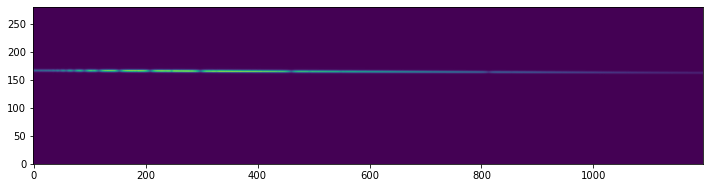

In [9]:
fig = plt.figure(figsize=(12,10))
plt.imshow(im,origin='lower',aspect='equal')

(150.0, 180.0)

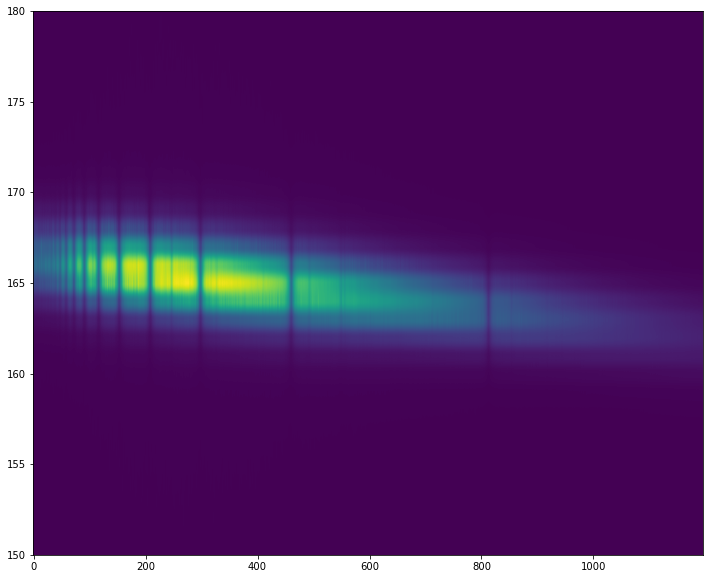

In [10]:
fig = plt.figure(figsize=(12,10))
plt.imshow(im,origin='lower',aspect='auto')
plt.ylim(150,180)

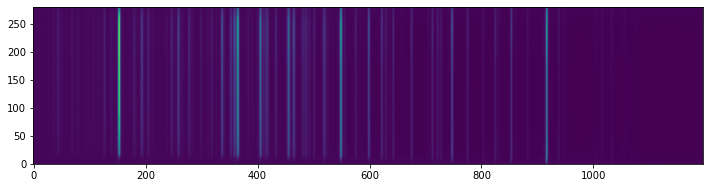

In [11]:
fig = plt.figure(figsize=(12,10))
plt.imshow(cim,origin='lower',aspect='equal')

# Trace the Spectrum

In [12]:
ny,nx = im.shape
x = np.arange(nx)
y = np.arange(ny)

In [13]:
par,cov=gaussfit(y,im[:,400])
gmodel=gaussian(y,*par)

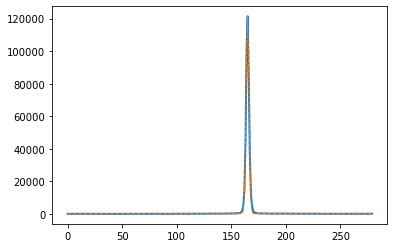

In [14]:
plt.plot(y,im[:,400],linewidth=2)
plt.plot(y,gmodel,linewidth=1,linestyle='dashed')

(150.0, 180.0)

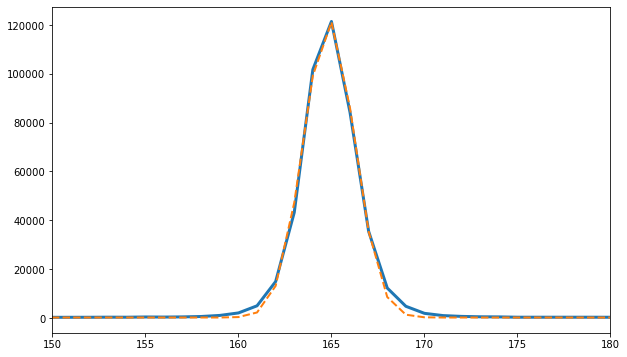

In [15]:
fig = plt.figure(figsize=(10,6))
plt.plot(y,im[:,400],linewidth=3)
plt.plot(y,gmodel,linewidth=2,linestyle='dashed')
plt.xlim(150,180)

In [16]:
def trace(im,yestimate=None,yorder=2,sigorder=4,step=10):
    """ Trace the spectrum.  Spectral dimension is assumed to be on the horizontal axis."""
    ny,nx = im.shape
    if yestimate is None:
        ytot = np.sum(im,axis=1)
        yestimate = np.argmax(ytot)
    # Smooth in spectral dimension
    # a uniform (boxcar) filter with a width of 50
    smim = ndimage.uniform_filter1d(im, 50, 1)
    nstep = nx//step
    # Loop over the columns in steps and fit Gaussians
    tcat = np.zeros(nstep,dtype=np.dtype([('x',float),('pars',float,4)]))
    for i in range(nstep):
        pars,cov = gaussfit(y[yestimate-10:yestimate+10],im[yestimate-10:yestimate+10,step*i+step//2])
        tcat['x'][i] = step*i+step//2
        tcat['pars'][i] = pars
    # Fit polynomail to y vs. x and gaussian sigma vs. x
    ypars = np.polyfit(tcat['x'],tcat['pars'][:,1],yorder)
    sigpars = np.polyfit(tcat['x'],tcat['pars'][:,2],sigorder)
    # Model
    mcat = np.zeros(nx,dtype=np.dtype([('x',float),('y',float),('sigma',float)]))
    xx = np.arange(nx)
    mcat['x'] = xx
    mcat['y'] = np.poly1d(ypars)(xx)
    mcat['sigma'] = np.poly1d(sigpars)(xx)
    return tcat, ypars, sigpars, mcat

In [17]:
tcat, ypars, sigpars, mcat = trace(im)

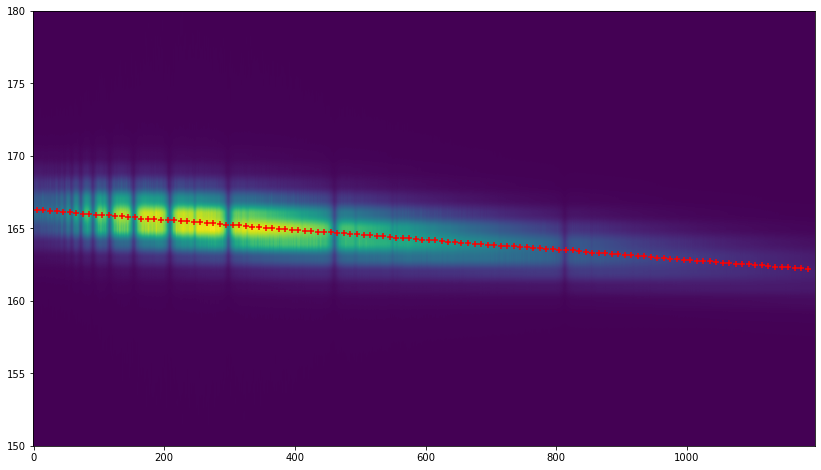

In [18]:
fig = plt.figure(figsize=(14,8))
plt.imshow(im,origin='lower',aspect='auto')
plt.ylim(150,180)
plt.scatter(tcat['x'],tcat['pars'][:,1],c='r',marker='+')

[-1.39912012e-08 -3.43113352e-03  1.66280823e+02]


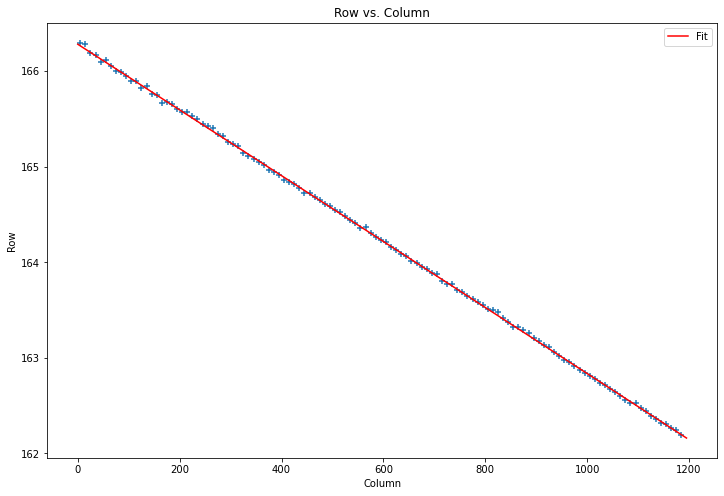

In [19]:
# Fit a polynomial to Y vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,1],marker='+')
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Row vs. Column')
plt.plot(mcat['x'],mcat['y'],c='r',label='Fit')
plt.legend()
print(ypars)

No handles with labels found to put in legend.


[-1.39912012e-08 -3.43113352e-03  1.66280823e+02]


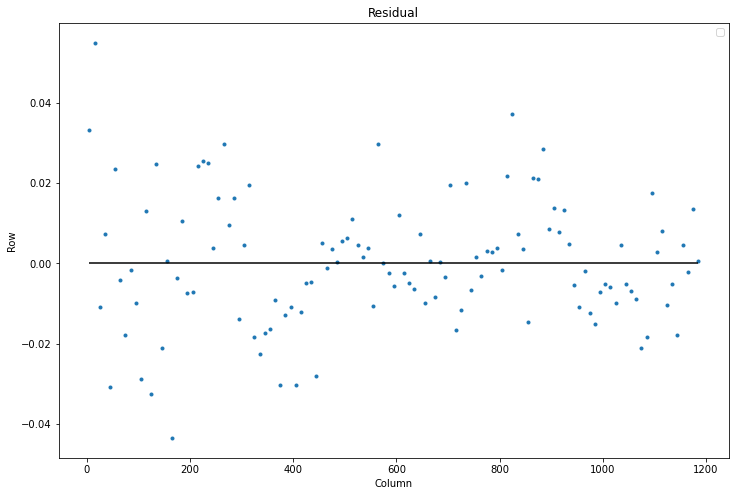

In [20]:
# Fit a polynomial to Y vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,1] - (np.poly1d(ypars)(tcat['x'])),marker='.')
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Residual')
# plt.plot(mcat['x'],mcat['y'],c='r',label='Fit')
plt.hlines(0, np.min(tcat['x']), np.max(tcat['x']), color='black')
plt.legend()
print(ypars)

[ 1.00881175e-12 -2.25433536e-09  1.78555705e-06 -5.79843313e-04
  1.38925593e+00]


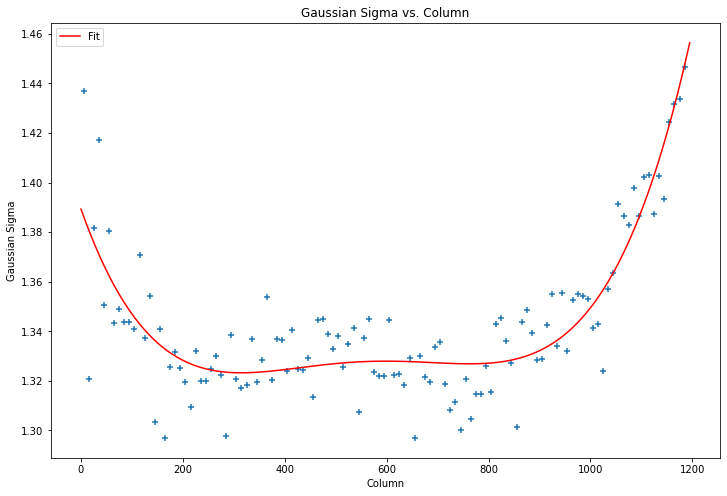

In [21]:
# Fit a polynomial to Gaussian Sigma vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,2],marker='+')
plt.xlabel('Column')
plt.ylabel('Gaussian Sigma')
plt.title('Gaussian Sigma vs. Column')
plt.plot(mcat['x'],mcat['sigma'],c='r',label='Fit')
plt.legend()
print(sigpars)

# Extract the Spectrum

In [22]:
def boxcar(im):
    """ Boxcar extract the spectrum"""
    ny,nx = im.shape
    ytot = np.sum(im,axis=1)
    yest = np.argmax(ytot)
    # Background subtract
    yblo = int(np.maximum(yest-50,0))
    ybhi = int(np.minimum(yest+50,ny))
    med = np.median(im[yblo:ybhi,:],axis=0)
    medim = np.repeat(med,ny).reshape(ny,nx)
    subim = im.copy()-medim
    # Sum up the flux
    ylo = int(np.maximum(yest-20,0))
    yhi = int(np.minimum(yest+20,ny))
    flux = np.sum(subim[ylo:yhi,:],axis=0)
    return flux

In [23]:
boxflux = boxcar(im)

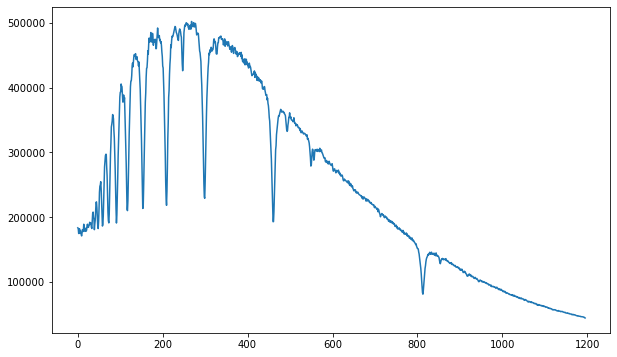

In [24]:
fig = plt.figure(figsize=(10,6))
plt.plot(boxflux)

We can improve the extraction by fitting a Gaussian to the profiles but now holding the center and Gaussian sigma fixed.  Only fit the height (i.e. flux) and constant offset (background).  This will allow us to properly weight each pixels.  This will improve the results especially for low S/N spectra.

In [25]:
def linefit(x,y,initpar,bounds,err=None):
    # Fit Gaussian profile to data with center and sigma fixed.
    # initpar = [height, center, sigma, constant offset]
    cen = initpar[1]
    sigma = initpar[2]
    gline = lambda x, amp, const=0: amp * np.exp(-(x-cen)**2 / (2*sigma**2)) + const
    line_initpar = [initpar[0],initpar[3]]
    lbounds, ubounds = bounds
    line_bounds = ([lbounds[0],lbounds[3]],[ubounds[0],ubounds[3]])
    return curve_fit(gline, x, y, p0=line_initpar, bounds=line_bounds, sigma=err)

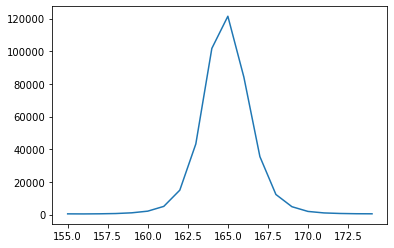

In [26]:
plt.plot(y[155:175],im[155:175,400])

In [27]:
Table(mcat)[400]

x,y,sigma
float64,float64,float64
400.0,164.9061313682917,1.324555850864078


In [28]:
initpar = [8e5, 164.906, 1.32455, 0.0]
bnds = ( [0,0,0,0], [1e8,0,0,1e4] )
pars0,cov0 = linefit(y[155:175],im[155:175,400],initpar=initpar,bounds=bnds)
pars = [pars0[0],164.906, 1.32455, pars0[1]]
print(pars)
lmodel = gaussian(y[155:175],*pars)

[121052.82859150822, 164.906, 1.32455, 1515.9809571785918]


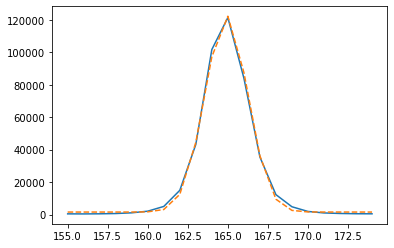

In [29]:
plt.plot(y[155:175],im[155:175,400])
plt.plot(y[155:175],lmodel,linestyle='dashed')

In [30]:
def extract(im,imerr=None,mcat=None,nobackground=False):
    """ Extract a spectrum"""
    ny,nx = im.shape
    x = np.arange(nx)
    y = np.arange(ny)
    # No trace information input, get it
    if mcat is None:
        tcat,ypars,sigpars,mcat=trace(im)
    # Loop over the columns and get the flux using the trace information
    cat = np.zeros(nx,dtype=np.dtype([('x',int),('pars',float,2),('perr',float,2),
                                      ('flux',float),('fluxerr',float)]))
    for i in range(nx):
        line = im[:,i].flatten()
        if imerr is not None:
            lineerr = imerr[:,i].flatten()
        else:
            lineerr = np.ones(len(line))   # unweighted
        # Fit the constant offset and the height of the Gaussian
        #  fix the central position and sigma
        ycen = mcat['y'][i]
        ysigma = mcat['sigma'][i]
        ht0 = np.maximum(line[int(np.round(ycen))],0.01)
        initpar = [ht0,ycen,ysigma,np.median(line)]
        if nobackground is True:
            initpar = [ht0,ycen,ysigma,0]
        # Only fit the region fight around the peak
        y0 = int(np.maximum(ycen-50,0))
        y1 = int(np.minimum(ycen+50,ny))
        bnds = ([0,ycen-1e-4,ysigma-1e-4,0],[1.5*ht0,ycen,ysigma,1.5*initpar[3]])
        if nobackground is True:
            bnds = ([0,ycen-1e-4,ysigma-1e-4,0],[1.5*ht0,ycen,ysigma,0.1])
        pars,cov = linefit(y[y0:y1],line[y0:y1],initpar=initpar,bounds=bnds,err=lineerr[y0:y1])
        perr = np.sqrt(np.diag(cov))
        # Gaussian area = ht*wid*sqrt(2*pi)
        flux = pars[0]*ysigma*np.sqrt(2*np.pi)
        fluxerr = perr[0]*ysigma*np.sqrt(2*np.pi)
        cat['x'][i] = i
        cat['pars'][i] = pars
        cat['perr'][i] = perr
        cat['flux'][i] = flux
        cat['fluxerr'][i] = fluxerr
    return cat

In [31]:
tcat,ypars,sigpars,mcat=trace(im)
scat = extract(im,imerr,mcat)

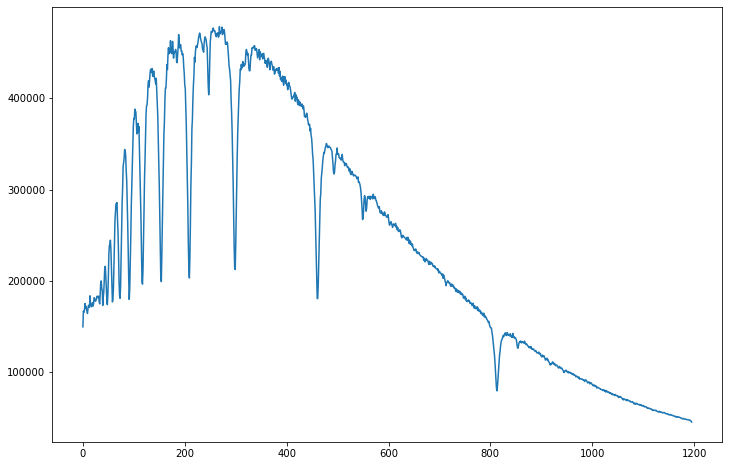

In [32]:
fig = plt.figure(figsize=(12,8))
plt.plot(scat['flux'])

In [33]:
Table(scat)

x,pars [2],perr [2],flux,fluxerr
int32,float64,float64,float64,float64
0,42970.75535769834 .. 107.75619506835936,2005.2225335060625 .. 20.588709069880185,149639.13228364478,6982.883066673911
1,47922.25486522069 .. 31.598603895677627,1884.3598032427378 .. 12.081885272937516,166812.53918385145,6559.266553691123
2,47580.87871148335 .. 1.3380752423433682e-12,1730.5130744506207 .. 6.6768928357251625,165555.7236899281,6021.249547171789
3,48118.92695279564 .. 16.853250897557977,1491.081251009753 .. 6.214531414824064,167358.97370932045,5186.022292870427
4,50371.214167156824 .. 3.0605781375564115e-13,1734.381185249639 .. 7.118871745949673,175120.84713337242,6029.759405941335
5,48902.77013370474 .. 18.150152920792138,1480.5867519848825 .. 7.3073874311722875,169946.52158525345,5145.323418634261
6,49576.18382440102 .. 30.08189879353387,1437.0960019911458 .. 8.074872263788524,172217.12232867174,4992.165973274053
7,48796.24883913567 .. 1.7660751829095633e-15,1749.6019598403593 .. 7.370951803671349,169439.67532314608,6075.302816767536
8,47919.204839831575 .. 1.0587460219651937e-10,1754.6839896131673 .. 6.130540248303558,166327.75856963854,6090.515399116019


We need to extract the comparison lamp spectrum the same way we did the object spectrum.

In [34]:
ccat = extract(cim,cimerr,mcat,nobackground=True)

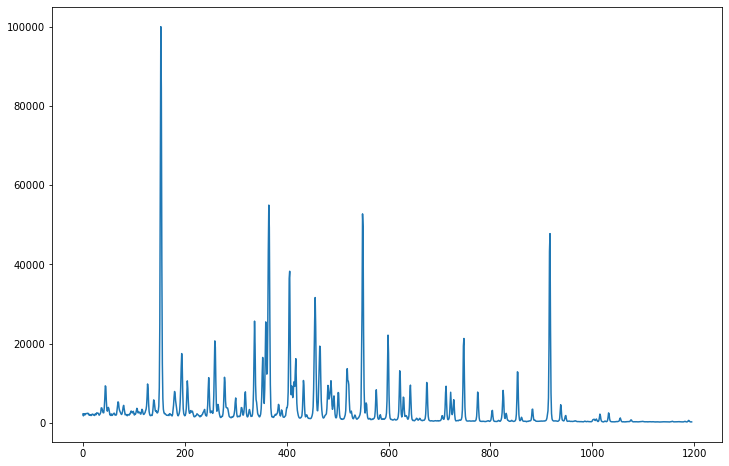

In [35]:
fig = plt.figure(figsize=(12,8))
plt.plot(ccat['flux'])

# Wavelength Solution

<img src="data\spec_reduction_data\hear340_520.gif" width=800 height=600 align="left"/>

The wavelength range that I was targeting was 3700 - 5250 Angstroms.

## Step 1.  Pick out the most prominent lines and find an intial wavelength solution

(140.0, 160.0)

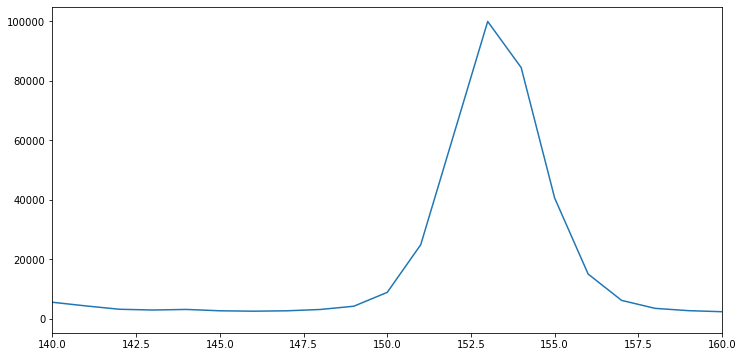

In [36]:
# The first line around 150 is 3888.6A
fig = plt.figure(figsize=(12,6))
plt.plot(ccat['flux'])
plt.xlim(140,160)

In [37]:
pars,cov=gaussfit(x[145:160],ccat['flux'][145:160])
print(pars)

[9.68794129e+04 1.53246075e+02 1.28384804e+00 3.42881438e+03]


(300.0, 400.0)

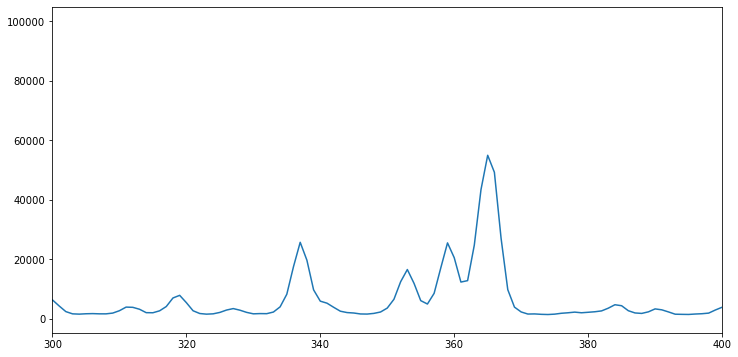

In [38]:
# The second line around 340 is 4158.6A
fig = plt.figure(figsize=(12,6))
plt.plot(ccat['flux'])
plt.xlim(300,400)

In [39]:
pars,cov=gaussfit(x[330:345],ccat['flux'][330:345])
print(pars)

[2.23529209e+04 3.37114623e+02 1.27451184e+00 2.64324462e+03]


(500.0, 600.0)

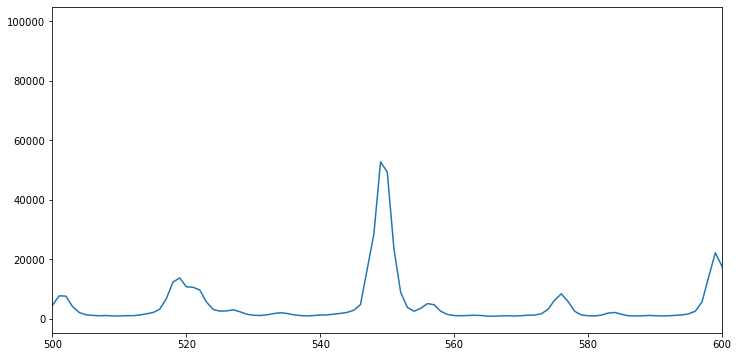

In [40]:
# The third line around 550 is 4471.5A
fig = plt.figure(figsize=(12,6))
plt.plot(ccat['flux'])
plt.xlim(500,600)

In [41]:
pars,cov=gaussfit(x[540:560],ccat['flux'][540:560])
print(pars)

[5.14193143e+04 5.49360035e+02 1.27431306e+00 2.67553530e+03]


(900.0, 960.0)

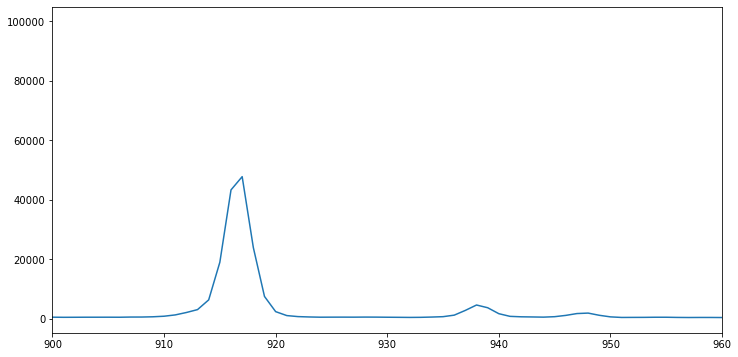

In [42]:
# The fourth line around 920 is 5015.7
fig = plt.figure(figsize=(12,6))
plt.plot(ccat['flux'])
plt.xlim(900,960)

In [43]:
pars,cov=gaussfit(x[910:930],ccat['flux'][910:930])
print(pars)

[4.87413048e+04 9.16610137e+02 1.15937488e+00 1.02632901e+03]


In [44]:
# Now fit a polynomial to the wavelengths versus column number.
col = [1.53246075e+02,3.37114623e+02,5.49360035e+02,9.16610137e+02]
wave = [3888.6,4158.6,4471.5,5015.7]

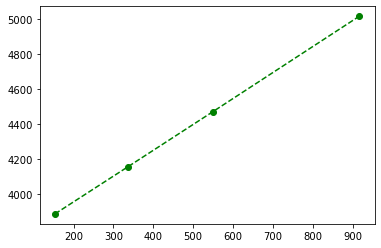

In [45]:
plt.plot(col,wave,'go--')

In [46]:
wcoef1 = np.polyfit(col,wave,1)
wmodel1 = np.poly1d(wcoef1)(x)
print(wcoef1)

[1.47682242e+00 3.66131168e+03]


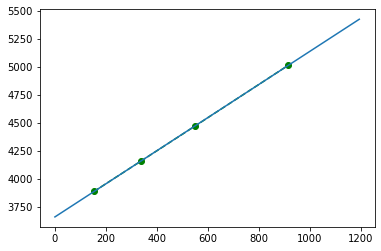

In [47]:
plt.plot(col,wave,'go--')
plt.plot(wmodel1)

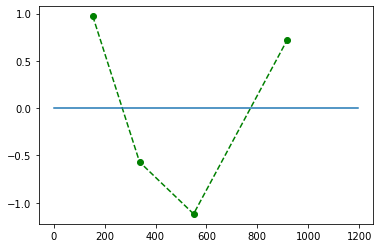

In [48]:
plt.plot(col,wave-np.poly1d(wcoef1)(col),'go--')
plt.plot([0,len(x)],[0,0])

In [49]:
wcoef2 = np.polyfit(col,wave,2)
wmodel2 = np.poly1d(wcoef2)(x)
print(wcoef2)

[1.35747454e-05 1.46198672e+00 3.66422669e+03]


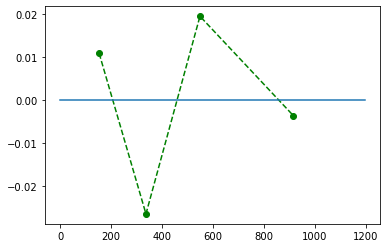

In [50]:
plt.plot(col,wave-np.poly1d(wcoef2)(col),'go--')
plt.plot([0,len(x)],[0,0])

## Step 2: Measure all of the lines and get their wavelengths from a linelist

In [51]:
def emissionlines(spec,thresh=None):
    """Measure the emission lines in an arc lamp spectrum. """
    nx = len(spec)
    x = np.arange(nx)
    
    # Threshold
    if thresh is None:
        thresh = np.min(spec) + (np.max(spec)-np.min(spec))*0.05
    
    # Detect the peaks
    sleft = np.hstack((0,spec[0:-1]))
    sright = np.hstack((spec[1:],0))
    peaks, = np.where((spec>sleft) & (spec>sright) & (spec>thresh))
    npeaks = len(peaks)
    print(str(npeaks)+' peaks found')
    
    # Loop over the peaks and fit them with Gaussians
    gcat = np.zeros(npeaks,dtype=np.dtype([('x0',int),('x',float),('xerr',float),('pars',float,4),('perr',float,4),
                                           ('flux',float),('fluxerr',float)]))
    resid = spec.copy()
    gmodel = np.zeros(nx)
    for i in range(npeaks):
        x0 = peaks[i]
        xlo = np.maximum(x0-6,0)
        xhi = np.minimum(x0+6,nx)
        initpar = [spec[x0],x0,1,0]
        bnds = ([0,x0-3,0.1,0],[1.5*initpar[0],x0+3,10,1e4])
        pars,cov = gaussfit(x[xlo:xhi],spec[xlo:xhi],initpar,bounds=bnds,binned=True)
        perr = np.sqrt(np.diag(cov))
        gmodel1 = gaussian(x[xlo:xhi],*pars)
        gmodel[xlo:xhi] += (gmodel1-pars[3])
        resid[xlo:xhi] -= (gmodel1-pars[3])
        # Gaussian area = ht*wid*sqrt(2*pi)
        flux = pars[0]*pars[2]*np.sqrt(2*np.pi)
        fluxerr = perr[0]*pars[2]*np.sqrt(2*np.pi)
        gcat['x0'][i] = x0
        gcat['x'][i] = pars[1]
        gcat['xerr'][i] = perr[1]
        gcat['pars'][i] = pars
        gcat['perr'][i] = perr
        gcat['flux'][i] = flux
        gcat['fluxerr'][i] = fluxerr
        #print(str(i+1)+' '+str(x0)+' '+str(pars))
        
    return gcat, gmodel

In [52]:
cflux = ccat['flux']
ecat,gmodel = emissionlines(cflux)

44 peaks found


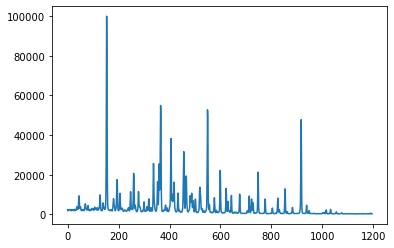

In [53]:
plt.plot(cflux)

(0.0, 100000.0)

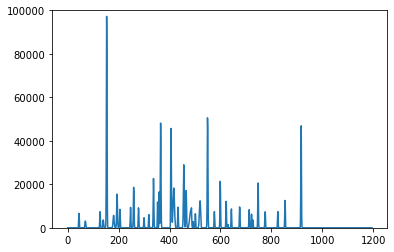

In [54]:
plt.plot(gmodel)
plt.ylim(0,1e5)

In [55]:
len(ecat)

44

## Load the HeAr linelist

In [59]:
ls data

 Volume in drive C is OS
 Volume Serial Number is 4E89-5B0C

 Directory of C:\Users\WillsPc\GitHub\ObservationalAstro_PHSX491\inclass_activities\data

12/02/2021  09:26 AM    <DIR>          .
12/02/2021  09:26 AM    <DIR>          ..
11/30/2021  09:32 AM    <DIR>          __MACOSX
11/09/2021  06:33 PM        73,512,000 DoubleCluster-0023B_red.fit
11/09/2021  06:33 PM         3,712,320 g_all_chip1.fit
12/15/2021  04:13 PM    <DIR>          spec_analysis_data
11/30/2021  09:32 AM    <DIR>          spec_reduction_data
12/15/2021  04:34 PM    <DIR>          spec_reduction_exercises_data
               2 File(s)     77,224,320 bytes
               6 Dir(s)  283,075,096,576 bytes free


In [61]:
linelist = Table.read('data/spec_reduction_data/hear_linelist.txt',format='ascii.commented_header')

In [62]:
linelist

wavelength
float64
3187.745
3243.689
3249.8
3307.228
3350.924
3376.436
3545.74
3560.4
3576.616


### Use our initial wavelength solution to get initial wavelengths for all of our lines

In [63]:
w0 = np.poly1d(wcoef2)(ecat['x'])

In [64]:
w0

array([3729.21203694, 3765.7671944 , 3850.44037212, 3868.59766505,
       3888.58914582, 3928.46678531, 3948.28184213, 3964.83022182,
       4026.15640414, 4044.21932335, 4072.14561184, 4103.70582857,
       4131.54549267, 4158.62330617, 4181.94004466, 4191.12071641,
       4199.78866366, 4259.39157089, 4261.50393182, 4276.23565491,
       4275.54986482, 4300.18264718, 4333.46720651, 4347.24442078,
       4374.36259147, 4379.30942359, 4387.70436475, 4400.73893744,
       4427.64725561, 4471.48096672, 4510.70146077, 4545.0463726 ,
       4579.34219204, 4589.91463811, 4609.49357003, 4657.83727985,
       4713.09210452, 4726.86303123, 4735.72731429, 4764.81401164,
       4805.96237875, 4879.75903462, 4921.8801524 , 5015.70431271])

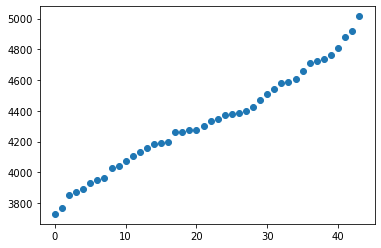

In [65]:
plt.scatter(np.arange(len(w0)),w0)

In [66]:
# Match up the lines to the linelist using a matching radius of 0.5A
match = np.zeros(len(ecat),bool)
wdiff = np.zeros(len(ecat),float)
wmatch = np.zeros(len(ecat),np.float64)
xmatch = np.zeros(len(ecat),float)
for i in range(len(ecat)):
    dist = np.abs(linelist['wavelength']-w0[i])
    mindist = np.min(dist)
    ind = np.argmin(dist)
    if mindist<0.5:
        match[i] = True
        wmatch[i] = linelist['wavelength'][ind]
        wdiff[i] = linelist['wavelength'][ind]-w0[i]
        xmatch[i] = ecat['x'][i]
    #print(str(i+1)+' '+str(mindist))

In [67]:
len(wdiff)

44

In [68]:
wmatch

array([3729.309,    0.   , 3850.581, 3868.528, 3888.648,    0.   ,
          0.   , 3964.729, 4026.191,    0.   ,    0.   , 4103.912,
       4131.724, 4158.591, 4181.884,    0.   ,    0.   , 4259.362,
          0.   ,    0.   ,    0.   , 4300.101,    0.   ,    0.   ,
          0.   ,    0.   , 4387.929,    0.   ,    0.   , 4471.479,
       4510.733, 4545.052, 4579.35 , 4589.898, 4609.567, 4657.901,
       4713.146, 4726.868, 4735.906, 4764.865, 4806.021, 4879.864,
       4921.931, 5015.68 ])

In [69]:
ecat = Table(ecat)
ecat['wave0'] = w0
ecat['wave'] = 0.0
gd, = np.where(match == True)
print(len(gd))
ecat['wave'][gd] = wmatch[gd]

28


In [70]:
ecat

x0,x,xerr,pars [4],perr [4],flux,fluxerr,wave0,wave
int32,float64,float64,float64,float64,float64,float64,float64,float64
44,44.4316921110526,0.05840801581436907,7155.105963822653 .. 2950.921662644224,343.7115701190978 .. 146.30250352241998,19877.741718671885,954.8719265782141,3729.2120369391105,3729.309
69,69.40904519663457,0.12548489137706947,3203.232479687452 .. 2108.116333022885,246.8080139381962 .. 155.25754295919367,12607.548660305632,971.4074970240097,3765.767194399493,0.0
127,127.22001447616509,0.07217972881733285,7523.013327656742 .. 2489.002835255121,416.2715064312232 .. 191.6958419771266,22555.5415974695,1248.0676120342978,3850.4403721161316,3850.581
139,139.6089222577432,0.15962756516769164,3738.112755851388 .. 2142.5620744543453,400.2558162128036 .. 218.29645761440423,13084.623745128289,1401.0269617324416,3868.5976650485572,3868.528
153,153.24602794049147,0.01569518116656832,99152.81269666128 .. 3930.66470885209,1154.8161834063148 .. 552.7495298333835,308267.5375445484,3590.3403190825,3888.5891458179253,3888.648
180,180.4381136213846,0.10158970295434523,5847.710882474081 .. 1821.5084218089826,330.59176667918854 .. 287.5826654744353,30051.869506717296,1698.9384105861939,3928.466785312905,0.0
194,193.94467573313395,0.04554997412997313,15485.569007904442 .. 2133.2688374362046,450.29696225576674 .. 265.9852618936531,57707.444140274136,1678.045332570329,3948.281842126096,0.0
205,205.22198245050066,0.04126359753807929,8635.285541347648 .. 2085.978755890613,264.4383000588593 .. 126.56033794829172,26844.382058570714,822.0553592245359,3964.830221824604,3964.729
247,246.99374184663645,0.049583628842992555,9383.908769239846 .. 2199.9134530735464,371.5760157275175 .. 163.31277533478115,26900.758149377132,1065.1932770233882,4026.1564041398956,4026.191


## Improve the wavelength solution

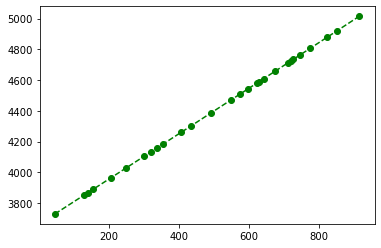

In [71]:
plt.plot(ecat['x'][gd],ecat['wave'][gd],'go--')

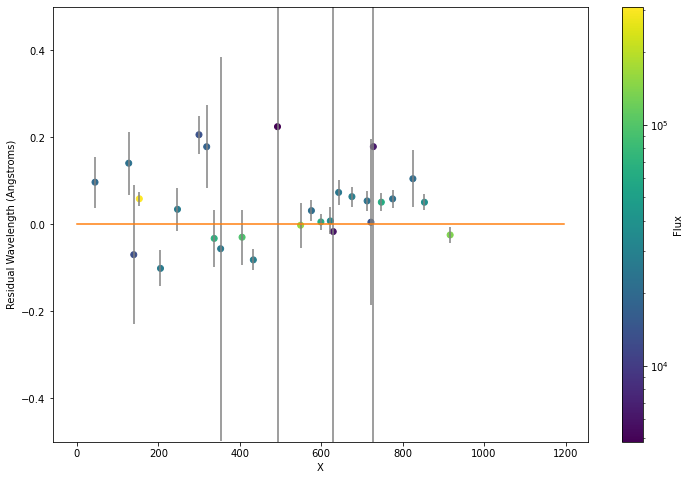

In [72]:
fig = plt.figure(figsize=(12,8))
norm = colors.LogNorm()
plt.scatter(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef2)(ecat['x'][gd]),
            c=ecat['flux'][gd],marker='o',norm=norm)
plt.errorbar(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef2)(ecat['x'][gd]),yerr=ecat['xerr'][gd],
             fmt='none',ecolor='gray')
plt.plot([0,len(x)],[0,0])
plt.xlabel('X')
plt.ylabel('Residual Wavelength (Angstroms)')
plt.ylim(-0.5,0.5)
plt.colorbar(label='Flux')

In [73]:
# Select only good lines with small positional errors
gd, = np.where((ecat['wave']>0) & (ecat['xerr']<0.1) & (ecat['flux']>3e4))
print(len(gd))

9


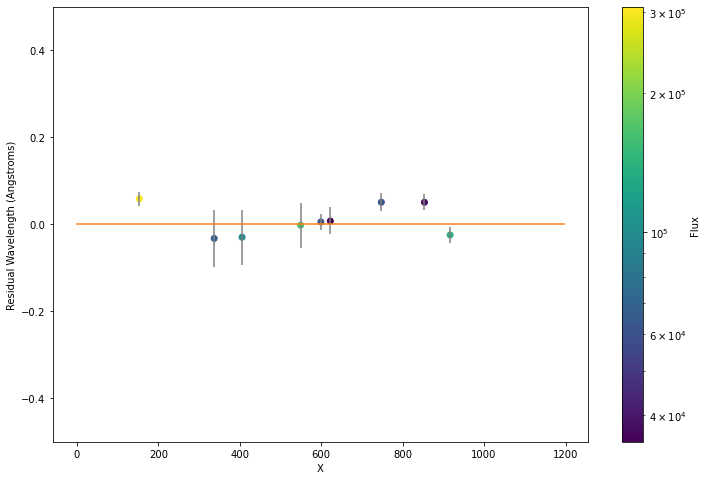

In [74]:
fig = plt.figure(figsize=(12,8))
norm = colors.LogNorm()
plt.scatter(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef2)(ecat['x'][gd]),
            c=ecat['flux'][gd],marker='o',norm=norm)
plt.errorbar(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef2)(ecat['x'][gd]),yerr=ecat['xerr'][gd],
             fmt='none',ecolor='gray')
plt.plot([0,len(x)],[0,0])
plt.xlabel('X')
plt.ylabel('Residual Wavelength (Angstroms)')
plt.ylim(-0.5,0.5)
plt.colorbar(label='Flux')

In [75]:
wcoef3 = np.polyfit(ecat['x'][gd],ecat['wave'][gd],3)
wmodel3 = np.poly1d(wcoef3)(x)
print(wcoef3)

[-2.77815188e-09  1.82603883e-05  1.45967231e+00  3.66454325e+03]


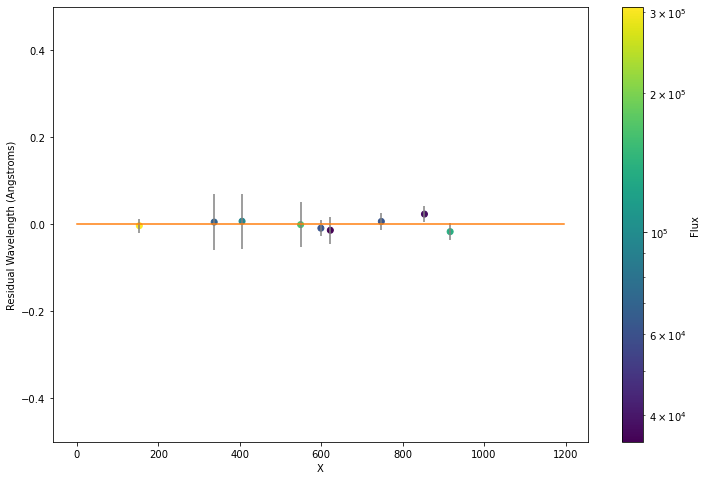

In [76]:
fig = plt.figure(figsize=(12,8))
norm = colors.LogNorm()
plt.scatter(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef3)(ecat['x'][gd]),
            c=ecat['flux'][gd],marker='o',norm=norm)
plt.errorbar(ecat['x'][gd],ecat['wave'][gd]-np.poly1d(wcoef3)(ecat['x'][gd]),yerr=ecat['xerr'][gd],
             fmt='none',ecolor='gray')
plt.plot([0,len(x)],[0,0])
plt.xlabel('X')
plt.ylabel('Residual Wavelength (Angstroms)')
plt.ylim(-0.5,0.5)
plt.colorbar(label='Flux')

## Add the final wavelengths to our object spectrum

In [77]:
# Add the wavelengths to the spectrum catalog
scat = Table(scat)
scat['wave'] = wmodel3

Text(0, 0.5, 'Flux')

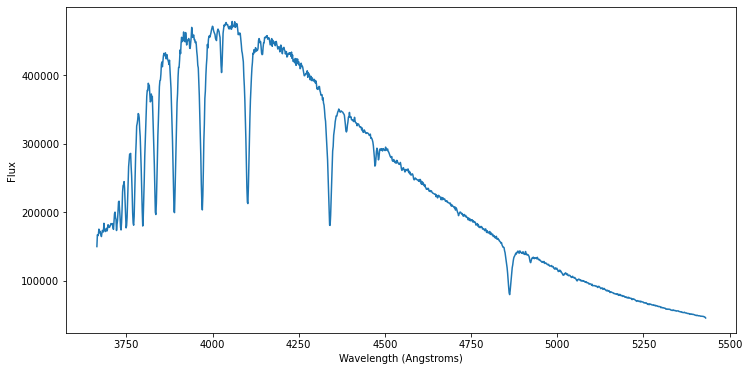

In [78]:
fig = plt.figure(figsize=(12,6))
plt.plot(scat['wave'],scat['flux'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')

# Continuum Normalization

Often we don't care about the absolute nature of the spectrum, but rather just the absorption lines.  Then it is useful to divide (normalize by) the continuum.

In [79]:
def continuum(spec,bin=50,perc=60,norder=4):
    """ Derive the continuum of a spectrum."""
    nx = len(spec)
    x = np.arange(nx)
    # Loop over bins and find the maximum
    nbins = nx//bin
    xbin1 = np.zeros(nbins,float)
    ybin1 = np.zeros(nbins,float)
    for i in range(nbins):
        xbin1[i] = np.mean(x[i*bin:i*bin+bin])
        ybin1[i] = np.percentile(spec[i*bin:i*bin+bin],perc)
    # Fit polynomial to the binned values
    coef1 = np.polyfit(xbin1,ybin1,norder)
    cont1 = np.poly1d(coef1)(x)
    
    # Now remove large negative outliers and refit
    gdmask = np.zeros(nx,bool)
    gdmask[(spec/cont1)>0.8] = True
    xbin = np.zeros(nbins,float)
    ybin = np.zeros(nbins,float)
    for i in range(nbins):
        xbin[i] = np.mean(x[i*bin:i*bin+bin][gdmask[i*bin:i*bin+bin]])
        ybin[i] = np.percentile(spec[i*bin:i*bin+bin][gdmask[i*bin:i*bin+bin]],perc)
    # Fit polynomial to the binned values
    coef = np.polyfit(xbin,ybin,norder)
    cont = np.poly1d(coef)(x)
    
    return cont,coef

In [80]:
cont,coef = continuum(scat['flux'],bin=20,norder=5)

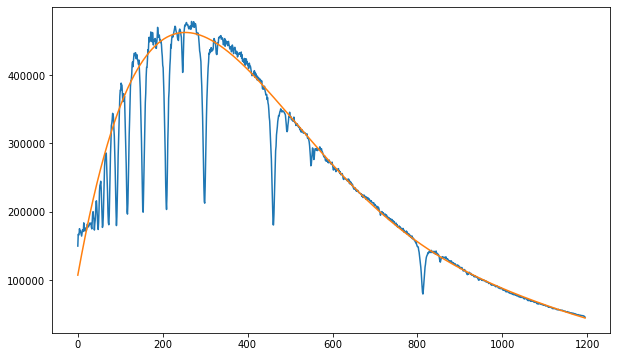

In [81]:
fig = plt.figure(figsize=(10,6))
plt.plot(scat['flux'])
plt.plot(cont)

(0.0, 1.2)

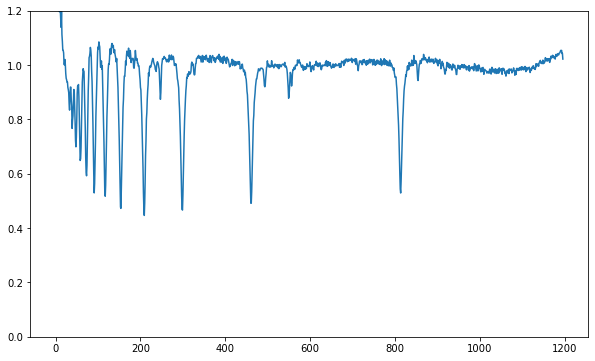

In [82]:
fig = plt.figure(figsize=(10,6))
plt.plot(scat['flux']/cont)
plt.ylim(0,1.2)

# Measuring Equivalent Widths

When doing abundances we want to equivalent widths of lines, basicaly the area in the line below the continuum (in Angstroms).

In [83]:
flux = scat['flux']/cont
wave = scat['wave']

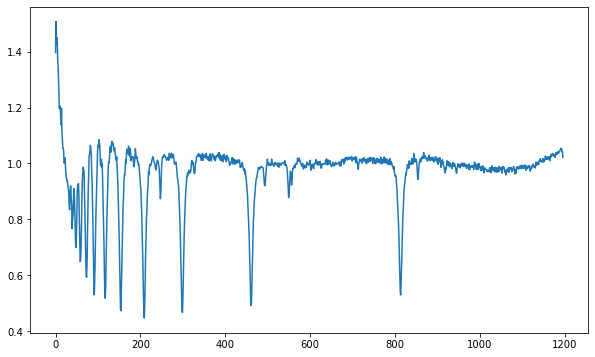

In [84]:
fig = plt.figure(figsize=(10,6))
plt.plot(flux)
# plt.xlim(780,850)
# plt.ylim(0,1.2)

In [85]:
# It's easy to measure the equivalent width
# Sum(1-flux)*dw
dw = wave[801]-wave[800]
print(np.sum(1-flux[780:850])*dw)

7.658185987054436


In [86]:
# To make this more accurate, let's fit a Gaussian to the line

In [87]:
initpar = [-0.5,wave[811],2.0,1.0]
bnds = ([-1.0,initpar[1]-5,0.1,0.5], [0.0,initpar[1]+5,20,1.5])
pars,cov = gaussfit(wave[750:850],flux[750:850],initpar,bounds=bnds)
gmodel = gaussian(wave[750:850],*pars)
print(np.abs(pars[0])*pars[2]*np.sqrt(2*np.pi))

7.47723731510449


(0.0, 1.2)

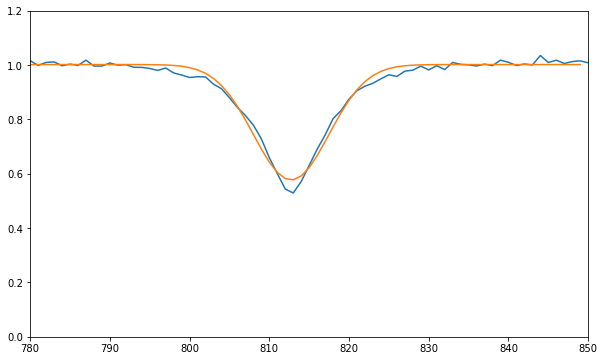

In [88]:
fig = plt.figure(figsize=(10,6))
x = np.arange(len(flux))
plt.plot(x,flux)
plt.plot(x[750:850],gmodel)
plt.xlim(780,850)
plt.ylim(0,1.2)

In [89]:
def voigt(x, height, cen, sigma, gamma, const=0.0, slp=0.0):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian sigma.

    """

    maxy = np.real(wofz((1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)
    return (height/maxy) * np.real(wofz(((x-cen) + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi) + const + slp*(x-cen)

In [90]:
def voigtfit(x,y,initpar=None,sigma=None,bounds=(-np.inf,np.inf)):
    """Fit a Voigt profile to data."""
    if initpar is None:
        initpar = [np.max(y),x[np.argmax(y)],1.0,1.0,np.median(y),0.0]
    func = voigt
    return curve_fit(func, x, y, p0=initpar, sigma=sigma, bounds=bounds)

In [91]:
def voigtarea(pars):
    """ Compute area of Voigt profile"""
    sig = np.maximum(pars[2],pars[3])
    x = np.linspace(-20*sig,20*sig,1000)+pars[1]
    dx = x[1]-x[0]
    v = voigt(x,np.abs(pars[0]),pars[1],pars[2],pars[3])
    varea = np.sum(v*dx)
    return varea

In [97]:
initpar = [-0.5,wave[811],2.0,1.0,1.0,0.0]
bnds = ([-1.0,initpar[1]-5,0.1,0.1,0.5,-0.5], [0.0,initpar[1]+5,20,20,1.5,0.5])
vpars,vcov = voigtfit(wave[780:850],flux[780:850],initpar,bounds=bnds)
vmodel = voigt(wave[780:850],*vpars)
print(vpars)
print(voigtarea(vpars))

[-4.84856223e-01  4.86147126e+03  1.00000000e-01  7.11370899e+00
  1.02144004e+00  3.64891637e-05]
10.49353991357828


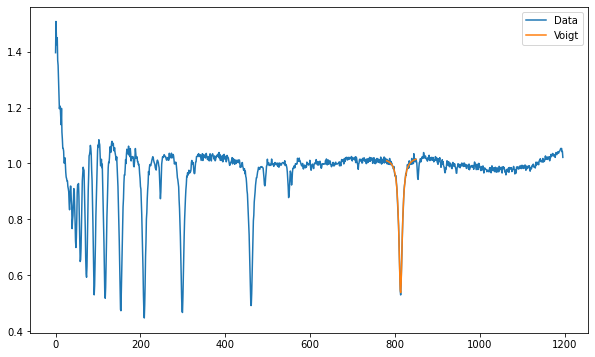

In [98]:
fig = plt.figure(figsize=(10,6))
x = np.arange(len(flux))
plt.plot(x,flux,label='Data')
plt.plot(x[780:850],vmodel,label='Voigt')
# plt.xlim(780,850)
# plt.ylim(0.2,1.3)
plt.legend()